# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
#!pip -q install ./python

The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
%config Completer.use_jedi = False

In [3]:
from unityagents import UnityEnvironment
import numpy as np

###### Note: Change to appropriate file location
env = UnityEnvironment(file_name=r"C:\Users\Ai\Documents\openAI\DeepRL_P3\Tennis_Windows_x86_64\Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]



In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1. If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01. Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping.

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

   -  After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
   - This yields a single score for each episode.

The environment is considered solved, when the average (over 100 episodes) of those scores is at least +0.5.

### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [6]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.04500000085681677
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: -0.004999999888241291
Total score (averaged over agents) this episode: 0.09500000160187483
Total score (averaged over agents) this episode: -0.004999999888241291


When finished, you can close the environment.

### 4. Build an Agent

##### 4.1. Actor / Critic Neural Networks

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorNN(nn.Module):
    
    def __init__(self, state_size, action_size):
        super(ActorNN, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, action_size)
        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.tanh(self.fc4(x))
        return x
    
    
class CriticNN(nn.Module):
    
    def __init__(self, state_size, action_size):
        super(CriticNN, self).__init__()
        self.fc1 = nn.Linear(state_size+action_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 64)
        self.fc4 = nn.Linear(64, 1)
        self.state_size = state_size
        self.action_size = action_size

    def forward(self, state, action):
        s = state.reshape(-1, self.state_size)
        a = action.reshape(-1, self.action_size)
        xs = torch.cat((s, a), dim=1)
        x = F.relu(self.fc1(xs))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

##### 4.2. Multi-Agent Deep Deterministic Policy Gradient (MADDPG)

In [8]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch
import torch.nn.functional as F
import torch.optim as optim


hyperparameters = {
    'BUFFER_SIZE' : int(1e6),  # replay buffer size
    'BATCH_SIZE' : 128,        # minibatch size
    'GAMMA' : 0.99,            # discount factor
    'TAU' : 0.001,             # for soft update of target parameters
    'LR_ACTOR' : 0.0001,       # learning rate of the actor
    'LR_CRITIC' : 0.0001,      # learning rate of the critic
    'WEIGHT_DECAY' : 0,        # L2 weight decay
    'UPDATE_EVERY' : 4,        # learn every UPDATE_EVERY time steps
    'step_n_updates' : 4       # number of updates during each step (from memory)
}

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"

class MADDPG:
    """Interacts with and learns from the environment."""

    def __init__(self, state_size, action_size, n_agents, random_seed):
        """Initialize an Agent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Networks 
        self.actor_local = ActorNN(state_size, action_size).to(device)
        self.actor_target = ActorNN(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=hyperparameters['LR_ACTOR'])

        # Critic Networks
        self.critic_local = CriticNN(state_size * n_agents, action_size * n_agents).to(device)
        self.critic_target = CriticNN(state_size * n_agents, action_size * n_agents).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), 
                                           lr=hyperparameters['LR_CRITIC'], 
                                           weight_decay=hyperparameters['WEIGHT_DECAY'])

        self.hard_update(self.actor_local, self.actor_target)
        self.hard_update(self.critic_local, self.critic_target)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, hyperparameters['BUFFER_SIZE'], hyperparameters['BATCH_SIZE'], random_seed)

        self.time_step = 0

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 1)
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, hyperparameters['TAU'])
        self.soft_update(self.actor_local, self.actor_target, hyperparameters['TAU'])

    def step(self, states, actions, rewards, next_states, dones, n_updates=1):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        self.time_step += 1

        self.memory.add(states, actions, rewards, next_states, dones)

        # Learn, if enough samples are available in memory
        if (len(self.memory) > hyperparameters['BATCH_SIZE']) and (self.time_step % hyperparameters['UPDATE_EVERY'] == 0):
            for i in range(n_updates):
                experiences = self.memory.sample()
                self.learn(experiences, hyperparameters['GAMMA'])

    def hard_update(self, local_model, target_model):
        """Hard update model parameters.
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)

    # from Banana
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1, scale_start=0.99):
        """Initialize parameters and noise process."""
        self.size = size
        self.seed = random.seed(seed)
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.scale_start = scale_start
        self.counter = 100
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)
        self.counter += 1
        self.scale = self.scale_start ** self.counter

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return torch.tensor(self.state * self.scale).float()

    
# from Banana
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


##### 4.3. Training

In [9]:
def train(n_episodes=20000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    scores = []
    mean_scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        state = env_info.vector_observations  
        agent.reset()
        score = np.zeros(num_agents)
        while True:
            action = agent.act(state)      
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
            agent.step(state, action, reward, next_state, done, hyperparameters['step_n_updates'])
            state = next_state
            score += reward
            if np.any(done):
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        mean_score = np.mean(scores_deque)
        mean_scores.append(mean_score)
        print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, mean_score), end="")

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.4f}'.format(i_episode, mean_score))

        if mean_score >= 2.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, mean_score))
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            break            
    return scores, mean_scores

In [10]:
agent = MADDPG(state_size, action_size, num_agents, 0)

scores, mean_scores = train()

Episode 100	Average Score: -0.0050
Episode 200	Average Score: -0.0050
Episode 300	Average Score: -0.0050
Episode 400	Average Score: -0.0050
Episode 500	Average Score: -0.0050
Episode 600	Average Score: -0.0050
Episode 700	Average Score: -0.0050
Episode 800	Average Score: -0.0050
Episode 900	Average Score: -0.0050
Episode 1000	Average Score: -0.0050
Episode 1100	Average Score: -0.0050
Episode 1200	Average Score: -0.0050
Episode 1300	Average Score: -0.0050
Episode 1400	Average Score: -0.0050
Episode 1500	Average Score: -0.0050
Episode 1600	Average Score: -0.0050
Episode 1700	Average Score: -0.0050
Episode 1800	Average Score: -0.0050
Episode 1900	Average Score: -0.0050
Episode 2000	Average Score: -0.0050
Episode 2100	Average Score: -0.0050
Episode 2200	Average Score: -0.0050
Episode 2300	Average Score: -0.0050
Episode 2400	Average Score: -0.0050
Episode 2500	Average Score: -0.0050
Episode 2600	Average Score: -0.0045
Episode 2700	Average Score: -0.0050
Episode 2800	Average Score: -0.0050
E

##### 4.4. Performance history

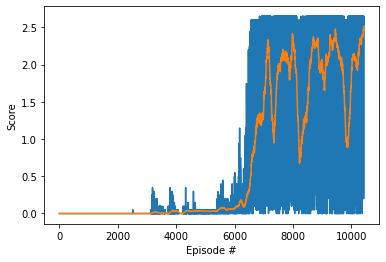

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot(scores, mean_scores):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(1, len(scores)+1), scores)
    plt.plot(np.arange(1, len(mean_scores)+1), mean_scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

plot(scores, mean_scores)

### 5. Test the trained Agent(s)

In [12]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))   
num_episodes = 10
scores = []
for i_episode in range(1,num_episodes+1):
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    state = env_info.vector_observations                   # get the current state (for each agent)
    score = np.zeros(num_agents)  
    while True:            
        action = agent.act(state)      
        env_info = env.step(action)[brain_name]
        next_state, reward, done = env_info.vector_observations, env_info.rewards, env_info.local_done
        state = next_state
        score += reward        
        if np.any(done):
            break 
    scores.append(np.mean(score))
    print('Averaged score between agents, episode {}: {}'.format(i_episode, np.mean(score)))

Averaged score between agents, episode 1: 2.600000038743019
Averaged score between agents, episode 2: 2.650000039488077
Averaged score between agents, episode 3: 2.600000038743019
Averaged score between agents, episode 4: 2.650000039488077
Averaged score between agents, episode 5: 2.600000038743019
Averaged score between agents, episode 6: 2.600000038743019
Averaged score between agents, episode 7: 2.650000039488077
Averaged score between agents, episode 8: 2.600000038743019
Averaged score between agents, episode 9: 2.650000039488077
Averaged score between agents, episode 10: 2.600000038743019


In [13]:
env.close()